### The Impact of Scale on Content Analysis of Goodreads Reviews

- We use content analysis: quantitative method for analysing the content of reviews
- Subsets of reviews with different types of focus and different scales (from 1 to 100 to 10,000 to 1 million reviews)


In [301]:
# This reload library is just used for developing the REPUBLIC hOCR parser 
# and can be removed once this module is stable.
%reload_ext autoreload
%autoreload 2

# This is needed to add the repo dir to the path so jupyter
# can load the modules in the scripts directory from the notebooks
import os
import sys
repo_dir = os.path.split(os.getcwd())[0]
print(repo_dir)
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import csv
import os

data_dir = '../data/GoodReads'

books_10k_file = os.path.join(data_dir, 'goodreads_reviews-books_above_10k_reviews_lang.csv.gz')
reviewers_5k_file = os.path.join(data_dir, 'goodreads_reviews-reviewers_above_5k_reviews.csv.gz')
random_1M_file = os.path.join(data_dir, 'goodreads_reviews-random_sample_1M.csv.gz')
author_file = os.path.join(data_dir, 'goodreads_book_authors.csv.gz') # author information
book_file = os.path.join(data_dir, 'goodreads_books.csv.gz') # basic book metadata


/Users/marijnkoolen/Code/Huygens/scale


## Loading and Merging Data

We start with a subset of reviews for frequently reviewed books. To see how this subset was created, go to the [Filtering Goodreads reviews](./Filtering-Goodreads-Reviews.ipynb) notebook. This subset contains all reviews for books that have at least 10,000 reviews each. 

We first load the reviews into a Pandas dataframe, then add metadata for the reviewed books from some of the datasets with book metadata.

In [34]:
# the review dataframe
review_df = pd.read_csv(books_10k_file, sep='\t', compression='gzip')



In [35]:
# get a list of book ids that are in the review dataset
review_book_ids = set(review_df.book_id.unique())

# load basic book metadata (only book and author id and book title)
book_df = pd.read_csv(book_file, sep='\t', compression='gzip', usecols=['book_id', 'author_id', 'title'])

# filter the book metadata to only the book ids in the review dataset
book_df = book_df[book_df.book_id.isin(review_book_ids)]

# load the author metadata to get author names 
author_df = pd.read_csv(author_file, sep='\t', compression='gzip', usecols=['author_id', 'name'])
author_df = author_df.rename(columns={'name': 'author_name'})

# merge the book and author metadata into a single dataframe, 
# keeping only author names for books in the review dataset
metadata_df = pd.merge(book_df, author_df, how='left')

# merge the review dataset with the book metadata
review_df = pd.merge(review_df, metadata_df, on='book_id')

We remove empty reviews as they are non-reviews (see [Filtering Goodreads Reviews](./Filtering-Goodreads-Reviews.ipynb) for details on how and why we do this).

In [36]:
print('Number of empty reviews:', len(review_df[review_df.review_length == 0]))
review_df = review_df[review_df.review_length > 0]

Number of empty reviews: 47


This datasets contains reviews for nine books that each have at least 10,000 reviews:

In [148]:
review_df.groupby(['author_name', 'title']).size()

author_name      title                                  
E.L. James       Fifty Shades of Grey (Fifty Shades, #1)    11176
John Green       The Fault in Our Stars                     20738
Markus Zusak     The Book Thief                             11297
Paula Hawkins    The Girl on the Train                      13401
Stephenie Meyer  Twilight (Twilight, #1)                    10532
Suzanne Collins  Catching Fire (The Hunger Games, #2)       11900
                 Mockingjay (The Hunger Games, #3)          13534
                 The Hunger Games (The Hunger Games, #1)    18613
Veronica Roth    Divergent (Divergent, #1)                  10739
dtype: int64

Suzanne Collins has three books, all part of the same trilogy, among the most frequently reviewed books:

In [149]:
review_df.author_name.value_counts()

Suzanne Collins    44047
John Green         20738
Paula Hawkins      13401
Markus Zusak       11297
E.L. James         11176
Veronica Roth      10739
Stephenie Meyer    10532
Name: author_name, dtype: int64

There are reviews in different languages:

In [150]:
review_df.review_lang.value_counts()

en         113338
es           1650
af            666
id            624
unknown       516
it            486
de            450
tl            385
cy            331
fr            302
so            283
pt            270
sv            254
nl            252
sl            245
no            227
ro            213
ca            186
pl            172
sw            156
da            155
tr            124
et            107
hr            103
vi             89
sk             86
hu             66
cs             63
sq             46
fi             45
lt             23
lv             17
Name: review_lang, dtype: int64

For content analysis, we'll remove the non-English reviews, so content can be more easily compared across reviews.

In [154]:
review_df = review_df[review_df.review_lang == 'en']

We start with analysing the reviews for a single book. A random pick from the book ids:

In [22]:
np.random.choice(list(review_book_ids))

7260188

In [155]:
book_id = 7260188
book_df = review_df[review_df.book_id == book_id]
book_df.title.drop_duplicates()

18617    Mockingjay (The Hunger Games, #3)
Name: title, dtype: object

The chosen book is *Mockingjay*, the third book in *The Hunger Games* trilogy by Suzanne Collins. Let's start with a quick look at the ratings to know if we can expect positive and/or negative reviews:

In [156]:

book_df.rating.value_counts()

5    4436
4    3833
3    2667
2    1068
1     346
0     257
Name: rating, dtype: int64

The majority of reviews have a positive rating. This is typical of online reviews. People don't choose books to read randomly, but those which they expect to like. Furthermore, people who liked a book are more likely willing to put effort into reviewing it. 

Let's look at the differences in review length:

The shortest review (in text characters): 5
The longest review (in text characters): 17786
The average review length: 628.2132148806219
The standard deviation in review lengths: 1013.8078487498349

Number of reviews with fewer than 100 characters: 2918
Number of reviews of below average length: 9144
Number of reviews of above average length: 3463


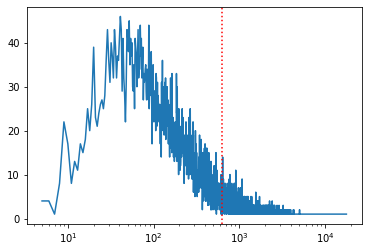

In [167]:
from collections import Counter

# count the number of reviews of each length
counts = book_df.review_length.value_counts().sort_index()
print('The shortest review (in text characters):', book_df.review_length.min())
print('The longest review (in text characters):', book_df.review_length.max())
print('The average review length:', book_df.review_length.mean())
print('The standard deviation in review lengths:', book_df.review_length.std())
print('\nNumber of reviews with fewer than 100 characters:', sum(book_df.review_length < 100))
print('Number of reviews of below average length:', sum(book_df.review_length < book_df.review_length.mean()))
print('Number of reviews of above average length:', sum(book_df.review_length > book_df.review_length.mean()))

dist = {length: count for length, count in counts.iteritems()}
book_df.review_length.value_counts()
x, y = zip(*book_df.review_length.value_counts().sort_index().iteritems())
plt.plot(x, y)
plt.axvline(x=book_df.review_length.mean(), color='red', linestyle='dotted')
plt.xscale('log')


The plot above shows the distribution of review lengths in number of characters per review. There is a large spread in review lengths. There are thousands of reviews with fewer than 100 characters. Based on typical average word lengths in English of just over 4 characters per word, plus whitespace between words, that means that these are reviews with fewer than 20 words. The average length is 628 characters (the red dotted line), while the longest is almost 18,000 characters long (roughly 3600 words).

*Slight tangent on the distribution*: The standard deviation is higher than the average length, signaling that this distribution is skewed towards the left (most reviews are shorter than the average). See the notebook on [Analysing Distributions](./Analyzing-Distributions.ipynb) for  a detailed analysis of the different types of distributions and our arguments on why it is important to know about them and take them into account when interpreting data.


Let's sample a review and look at the text.

In [105]:
sample_df = book_df.sample(1)

sample_df.iloc[0,11]



'After the first two books I had in my mind a mapped out ending of how this last book would go. Katniss would kill Snow in a big epic sequence of events, she would choose the man she loved most, and Panem would no longer be a horrid place.   Well that was not how this book went at all. And at first I was very disappointing to realize that all my previous ideas were getting twisted to something I no longer recognized. But then I stopped trying to predict what I thought should happen and I just read it how it was happening.   By the end of the book I realized how true and how perfect the ending was. This book series was never a "fairy tale" story. In war things don\'t end with sunshine and butterflies. They end with broken people trying to pick up the pieces of there life and put them back together the best way they can. That is the most heroic effort of all. Not killing President Snow, not defeating an entire army all by yourself. No, a true hero is someone who has been through hell and

This review describes a reading experience with some surprises and realizations. The ending of the book is praised in particular.

Let's compare a small sample of 10 reviews:

In [49]:
def get_sample_review_texts(sample_df):
    """return the review texts from a sample dataframe."""
    num_rows = len(sample_df)
    for row_num in range(0, num_rows):
        yield sample_df.iloc[row_num,11]

sample_size = 10
sample_df = book_df.sample(sample_size)

for ri, review_text in enumerate(get_sample_review_texts(sample_df)):
    print(f'review {ri+1}:', review_text)
    print('\n')

review 1: I really loved how well this book wrapped up the series. The series is amazing and I think that they really needed every quality that Mockingjay had to effectively finish the series.


review 2: Loved the book, loved the series.   Frequently took me to places I didn't predict, which is a nice change of pace.


review 3: im only giving this book three stars because i am comparing it to the other two books. thos had to be the worst one out of the 3. it was just not as action-y as i wanted it to be. and then i wish that katniss actually went to go kill snow instead of that bomb happening. i love how there were so many deaths though because i hate happy endings. and im happy peeta n katniss ended up together in tthe end. but overall not the best one, and for the last book, that iz a disappointment


review 4: I devoured this book fairly quickly. But by all means, it is my least favorite book of the trilogy.   Some of my issues with the turn of this story is how reminiscent it is 

Many reviews are very short, just one or two short sentences. Many reviewers mention the ending. This book being the last of a trilogy, this is not unexpected, as this book wraps up a longer narrative. We see quite some difference of opinion.

Taking a first step into a more quantitative analysis of the content, we do a Keyword in Context (KWiC) search for  the words 'end', 'ended' and 'ending' to get insight in what reviewers say about it.

In [64]:
import re


def kwic(pattern, reviews):
    for review in reviews:
        for match in re.findall(r'(.{40}\b' + pattern + r'\b.{40})', review):
            print(f'{match[1]: <15}{match[0]}')
            
def kwic(pattern, reviews, word_boundaries=True):
    pattern = pattern if not word_boundaries else r'\b' + pattern + r'\b'
    for review in reviews:
        for match in re.finditer(pattern, review):
            start = match.start(0) - 40 if match.start(0) > 40 else 0
            end = match.end(0) + 40
            print(f'{match[1]: <15}{review[start:end]}')
            
pattern = '(end|ends|ended|ending|endings)'
kwic(pattern, get_sample_review_texts(sample_df))

endings        many deaths though because i hate happy endings. and im happy peeta n katniss ended up 
ended          y endings. and im happy peeta n katniss ended up together in tthe end. but overall no
end            eta n katniss ended up together in tthe end. but overall not the best one, and for 
ends           e story a complete injustice in how she ends the book.   I am not referring to the E
ended          t disappointed me that Katniss' journey ended so...ehh...for the lack of a better ter
ending         h and was still enjoyable and liked the ending. Just missed the Girl on Fire and only 
ending         llowing this last book. I did enjoy the ending, I just wish the author would have slow




Another way to get insight in the content of multiple reviews is to make frequency lists.

In [74]:
import re

tf = Counter()
for text in get_sample_review_texts(sample_df):
    # split the texts on any non-word characters
    words = re.split(r'\W+', text.strip())
    # count the number of times each word occurs across the review texts
    tf.update(words)

tf.most_common(20)

[('the', 55),
 ('I', 28),
 ('of', 25),
 ('and', 24),
 ('to', 18),
 ('that', 16),
 ('this', 14),
 ('book', 13),
 ('in', 13),
 ('a', 12),
 ('it', 10),
 ('as', 10),
 ('series', 9),
 ('was', 9),
 ('not', 9),
 ('', 8),
 ('but', 8),
 ('is', 7),
 ('s', 7),
 ('how', 6)]

How often do 'end' and 'ending' appear in these 10 reviews?

In [75]:
for term in ['end', 'ends', 'ended', 'ending', 'endings']:
    print(f'{term}:', tf[term])


end: 1
ends: 1
ended: 2
ending: 2
endings: 1


In [78]:
print('Number of words:', sum(tf.values()))
print('Number of distinct words:', len(tf.keys()))


Number of words: 818
Number of distinct words: 373


We can also use some of the many wonderful open source Natural Language Processing (NLP) tools to have more control on the textual content. We use [Spacy](https://spacy.io) to parsed the reviews to have access to the individual sentences and words, and get additional information on word forms, part-of-speech, lemmas, etc.

We start with listing all entities that Spacy identified in the sample of reviews.

In [68]:
import spacy

# load the large model for English
nlp = spacy.load('en_core_web_lg')

# use nlp to parse each text and store the parsed results as a list of docs
docs = [nlp(text) for text in get_sample_review_texts(sample_df)]

# iterate over the docs, then over the entities in each doc and count them
tf = Counter([entity.text for doc in docs for entity in doc.ents])

tf.most_common()


[('one', 5),
 ('two', 3),
 ('Katniss', 3),
 ('Suzanne Collins', 2),
 ('Peeta', 2),
 ('Mockingjay', 1),
 ('three', 1),
 ('3', 1),
 ('katniss', 1),
 ('peeta n katniss', 1),
 ('WWII', 1),
 ('Harry Potter', 1),
 ('the City Center', 1),
 ("Snow's", 1),
 ('Epilogue', 1),
 ('3-3.5', 1),
 ('2', 1),
 ('first', 1),
 ('the Hunger Games', 1),
 ('the Girl on Fire', 1)]

There is only a short list of entities found in the 10 reviews, most appearing only once. If we look not only at named entities, but at all noun phrases, we get a longer list:

In [79]:
# instead of entities, we can also look at noun-phrases
tf = Counter([ne.text for doc in docs for ne in doc.noun_chunks])

tf.most_common()


[('I', 28),
 ('it', 10),
 ('this book', 8),
 ('i', 7),
 ('she', 6),
 ('the series', 4),
 ('me', 4),
 ('you', 4),
 ('her', 3),
 ('the story', 3),
 ('Katniss', 3),
 ('they', 2),
 ('the book', 2),
 ('Suzanne Collins', 2),
 ('the action', 2),
 ('everything', 2),
 ('It', 2),
 ('the ending', 2),
 ('The series', 1),
 ('every quality', 1),
 ('Mockingjay', 1),
 ('places', 1),
 ('a nice change', 1),
 ('pace', 1),
 ('three stars', 1),
 ('the other two books', 1),
 ('thos', 1),
 ('action-y', 1),
 ('katniss', 1),
 ('snow', 1),
 ('that bomb', 1),
 ('so many deaths', 1),
 ('happy endings', 1),
 ('peeta n katniss', 1),
 ('tthe end', 1),
 ('the last book', 1),
 ('all means', 1),
 ('my least favorite book', 1),
 ('the trilogy', 1),
 ('my issues', 1),
 ('the turn', 1),
 ('this story', 1),
 ('WWII', 1),
 ('its imagery', 1),
 ('the more recent military endeavors', 1),
 ('an issue', 1),
 ('an avid reader', 1),
 ('the correlations', 1),
 ('a fan', 1),
 ('the imagery', 1),
 ('the Harry Potter series', 1),
 ('

Many of these noun chunks are pronouns like 'I', 'me', 'you', 'she', 'her', 'they'. These are common in reviews, as reviewers often describe their personal reading experience and the affect that the book had on them. In a small sample, they get in way of seeing what content aspects are mentioned.

Spacy adds word form information to each word in the document. We can easily filter out common stopwords to get a better view of the content words that are mentioned.

In [70]:
tf = Counter([token.text for doc in docs for token in doc if not token.is_stop])

tf.most_common(20)


[('.', 41),
 (',', 25),
 ('book', 13),
 ('series', 9),
 ('  ', 6),
 ('loved', 4),
 ('books', 4),
 ('story', 4),
 ('Katniss', 4),
 ('action', 3),
 ('-', 3),
 ('favorite', 3),
 ('military', 3),
 ('enjoy', 3),
 ('missed', 3),
 ('final', 3),
 ('...', 3),
 ('needed', 2),
 ('change', 2),
 ('m', 2)]

Now we see many punctuation symbols. Let's filter those out as well.

In [71]:
tf = Counter([token.text for doc in docs for token in doc if not token.is_stop and not token.is_punct])

tf.most_common(20)


[('book', 13),
 ('series', 9),
 ('  ', 6),
 ('loved', 4),
 ('books', 4),
 ('story', 4),
 ('Katniss', 4),
 ('action', 3),
 ('favorite', 3),
 ('military', 3),
 ('enjoy', 3),
 ('missed', 3),
 ('final', 3),
 ('needed', 2),
 ('change', 2),
 ('m', 2),
 ('3', 2),
 ('wish', 2),
 ('katniss', 2),
 ('went', 2)]

The most common words are clearly related to the book domain (such as *book*, *books*, *series*, *story*) and the review domain (*loved*, *favorite*, *feenjoylt*, *missed*, *wish*). Notice that there are many morphological variants of each other. 

We can also count the word lemmas instead of the surface variants in the text:

In [72]:
tf = Counter([token.lemma_ for doc in docs for token in doc if not token.is_stop and not token.is_punct])

tf.most_common(20)


[('book', 17),
 ('series', 9),
 ('love', 7),
 ('  ', 6),
 ('end', 4),
 ('story', 4),
 ('Katniss', 4),
 ('change', 3),
 ('action', 3),
 ('ending', 3),
 ('favorite', 3),
 ('military', 3),
 ('reader', 3),
 ('like', 3),
 ('enjoy', 3),
 ('miss', 3),
 ('moment', 3),
 ('final', 3),
 ('amazing', 2),
 ('need', 2)]

Now we also see *end* as a common word. 

### Zooming out to more reviewers

With 10 short reviews we can only see a few commonalities and distinctions. Several mention the ending, some like and some don't. A quantitative perspective doesn't give us much more than a close reading of the reviews. 

If we zoom out to a larger group of 1000 reviews, we get a more stable picture of what aspects are commonly mentioned. But now a different problems rears up.

In [168]:
sample_size = 1000
sample_df = book_df.sample(sample_size)
docs = [nlp(text) for text in get_sample_review_texts(sample_df)]

# calculate the term frequency of individual words
tf = Counter([token.lemma_ for doc in docs for token in doc if not token.is_stop and not token.is_punct])

tf.most_common(20)


[('book', 1786),
 ('  ', 1221),
 ('Katniss', 874),
 ('like', 724),
 ('read', 700),
 ('end', 639),
 ('series', 587),
 ('love', 573),
 ('think', 530),
 ('character', 473),
 ('feel', 423),
 ('good', 422),
 ('ending', 416),
 ('Peeta', 387),
 ('go', 316),
 ('story', 313),
 ('Collins', 305),
 ('want', 302),
 ('know', 289),
 ('Games', 283)]

This list is very similar to the one for ten reviews. The book and review domain terms, plus the names of the book, author and main characters. 

Plain word lists are a quick way to get an overview of what is common across a set of reviews. Apart from total word counts, we can also count each word once per document regardless of how frequently the reviewer uses it, so that we get insight in how many reviewers mention a specific term, e.g. 'ending'. With each review being a document, this frequency is known as the *document frequency*.

In [169]:
def get_word_tokens(doc):
    """Return only tokens that are not stopwords and not punctuation."""
    return [token for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]

def get_doc_token_set(doc, use_lemma=False):
    """Return the set of tokens in a document (no repetition), either as plain term or as lemma."""
    return set([token.lemma_ if use_lemma else token.text for token in get_word_tokens(doc)])
    
df = Counter([token for doc in docs for token in get_doc_token_set(doc, use_lemma=True)])

df.most_common(20)

[('book', 643),
 ('series', 393),
 ('read', 389),
 ('end', 387),
 ('like', 371),
 ('Katniss', 322),
 ('love', 315),
 ('ending', 313),
 ('good', 288),
 ('think', 283),
 ('character', 255),
 ('feel', 229),
 ('trilogy', 199),
 ('Collins', 199),
 ('want', 194),
 ('story', 193),
 ('way', 193),
 ('time', 188),
 ('go', 185),
 ('Games', 183)]

This is quite insightful. There are 387 reviews (38.7% of the 1000 in the sample) that mention the word *end* and 315 reviews (could be many of the same reviews) that mention *ending*. Also, 255 reviewers mention the word *character*, and 193 mention *story*. 

But what is the problem that rears up here? Let's look at the total number of words and distinct word forms:

In [170]:
print('Number of words:', sum(tf.values()))
print('Number of distinct words:', len(tf.keys()))


Number of words: 46138
Number of distinct words: 5227


The 1000 reviews contain 46,138 words in total, and 5,227 distinct words. Above, we have looked at only the 20 most frequent ones. What are these remaining 5,207 words?

This is where the highly skewed distribution of word frequencies throws up barriers to analysis. How do we get a good overview of what those low-frequency are?

In [171]:
sizes = [10, 20, 100, 200]
for size in sizes:
    sum_top = sum([freq for term, freq in tf.most_common(size)])
    print(f'Sum frequency of top {size} terms: {sum_top} (fraction: {sum_top / sum(tf.values()): >.2f})')


Sum frequency of top 10 terms: 8107 (fraction: 0.18)
Sum frequency of top 20 terms: 11563 (fraction: 0.25)
Sum frequency of top 100 terms: 21840 (fraction: 0.47)
Sum frequency of top 200 terms: 27168 (fraction: 0.59)


These top 20 terms represent only 25% of all words. Even if we look at the top 200 words, we're ignoring half of the text. 

In [172]:
tf_lemma_pos = Counter([(token.lemma_, token.pos_) for doc in docs for token in doc if not token.is_stop and not token.is_punct])

tf_lemma_pos.most_common(20)


[(('book', 'NOUN'), 1785),
 (('  ', 'SPACE'), 1221),
 (('Katniss', 'PROPN'), 874),
 (('read', 'VERB'), 633),
 (('series', 'NOUN'), 575),
 (('think', 'VERB'), 530),
 (('character', 'NOUN'), 473),
 (('feel', 'VERB'), 417),
 (('ending', 'NOUN'), 416),
 (('love', 'VERB'), 416),
 (('good', 'ADJ'), 409),
 (('Peeta', 'PROPN'), 387),
 (('like', 'SCONJ'), 371),
 (('end', 'NOUN'), 354),
 (('go', 'VERB'), 315),
 (('story', 'NOUN'), 313),
 (('like', 'VERB'), 306),
 (('Collins', 'PROPN'), 305),
 (('want', 'VERB'), 302),
 (('know', 'VERB'), 289)]

In [299]:
from collections import defaultdict

tf_lemma_pos = Counter([(token.lemma_, token.pos_) for doc in docs for token in doc if not token.is_stop and not token.is_punct])

all_pos = defaultdict(int)
low_pos = defaultdict(int)
one_pos = defaultdict(int)
for lemma, pos in tf_lemma_pos:
    all_pos[pos] += tf_lemma_pos[(lemma, pos)]
    if tf_lemma_pos[(lemma, pos)] <= 5:
        low_pos[pos] += tf_lemma_pos[(lemma, pos)]
    if tf_lemma_pos[(lemma, pos)] == 1:
        one_pos[pos] += tf_lemma_pos[(lemma, pos)]

print('Word form\tAll TF (frac)\tTF <= 5 (frac)\tTF = 1 (frac)')
print('----------------------------------------------')
for pos in all_pos:
    all_frac = round(all_pos[pos] / sum(all_pos.values()), 2)
    low_frac = round(low_pos[pos] / sum(low_pos.values()), 2)
    one_frac = round(one_pos[pos] / sum(one_pos.values()), 2)
    print(f'{pos: <12}\t{all_pos[pos]: > 6}{all_frac: >6.2f}\t{low_pos[pos]: >6}{low_frac: >6.2}\t{one_pos[pos]: >6}{one_frac: >6.2}')
    

Word form	All TF (frac)	TF <= 5 (frac)	TF = 1 (frac)
----------------------------------------------
VERB        	 12830  0.28	  1671  0.21	   564  0.19
NOUN        	 16541  0.36	  2876  0.36	  1014  0.34
ADJ         	  6866  0.15	  1757  0.22	   674  0.22
PROPN       	  4738  0.10	   715  0.09	   408  0.13
SCONJ       	   418  0.01	     4   0.0	     1   0.0
NUM         	   481  0.01	   121  0.02	    49  0.02
ADV         	  2438  0.05	   502  0.06	   210  0.07
X           	    51  0.00	    41  0.01	    26  0.01
INTJ        	   407  0.01	   141  0.02	    35  0.01
SPACE       	  1221  0.03	     0   0.0	     0   0.0
PUNCT       	    32  0.00	    32   0.0	    22  0.01
CCONJ       	    12  0.00	    12   0.0	     0   0.0
PRON        	    17  0.00	    17   0.0	     4   0.0
PART        	    35  0.00	     0   0.0	     0   0.0
ADP         	    40  0.00	    20   0.0	    10   0.0
DET         	    10  0.00	    10   0.0	     6   0.0
SYM         	     1  0.00	     1   0.0	     1   0.0


Above we see the proportion of Part-Of-Speech tags across all words and across words that occur at most five times  and at most once. **Remember, this is after removal of stopwords and punctuation**.

- First, the largest categories overall are nouns (36%), verbs (28%), adjectives (15%), proper nouns (10%) and adverbs (5%). Proper nouns refer to single identifiable entities.

- Among the less frequent words, the proportion of nouns and adverbs remain stable, the proportion of verbs drop, while the number of adjectives and proper nouns go up. 

In other words, the tail has relatively many adjectives and entities, but also many other nouns. In terms of content analysis, these are important categories. Of course, with 1000 reviews and only a few thousand of these words, it is possible to go through all of them to get insights in what they are and how they relate to the book, the reading experience or something else. If we were to scale up to tens of thousands or millions of reviews, this would become increasingly infeasible. 


In [303]:
from itertools import combinations
from scripts.text_tail_analysis import filter_pos, sentence_iter, get_lemma_pos

# adding pronouns to explore the link with the reviewer and their reading experience
content_pos = ['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV', 'PRON'] 
            
cooc = Counter()
for sent in sentence_iter(docs):
    content_tokens = filter_pos(sent, content_pos)
    term_pairs = [term_pair for term_pair in combinations(get_lemma_pos(content_tokens), 2)]
    cooc.update(term_pairs)

len(cooc)

174061

In [311]:
# what are adjective referring to?
from scripts.text_tail_analysis import get_lemma_pos_tf_index, group_by_head, group_by_child

tf_lemma_pos = get_lemma_pos_tf_index(docs)
head_group = group_by_head(docs, tf_lemma_pos, ['ADJ', 'NOUN', 'PROPN'], max_threshold=5, min_threshold=0)

token_lemma_pos = ('story', 'NOUN')
if token_lemma_pos in head_group:
    print(token_lemma_pos)
    print('\t', head_group[token_lemma_pos])
    print()
    
for head in head_group:
    if sum(head_group[head].values()) < 20:
        continue
    print(head)
    print('\t', head_group[head])
        



('story', 'NOUN')
	 Counter({('normal', 'ADJ'): 2, ('winded', 'ADJ'): 1, ('quest', 'NOUN'): 1, ('stand', 'NOUN'): 1, ('back', 'NOUN'): 1, ('starting', 'ADJ'): 1, ('demise', 'NOUN'): 1, ('info', 'NOUN'): 1, ('reactionary', 'ADJ'): 1, ('phenomal', 'ADJ'): 1, ('answering', 'NOUN'): 1, ('youthful', 'ADJ'): 1, ('back', 'ADJ'): 1, ('exact', 'ADJ'): 1, ('fall', 'NOUN'): 1, ('optimistic', 'ADJ'): 1, ('distopian', 'ADJ'): 1, ('dynamic', 'ADJ'): 1, ('overarching', 'ADJ'): 1, ('vampire', 'NOUN'): 1, ('POV', 'PROPN'): 1})

('feel', 'VERB')
	 Counter({('incomplete', 'ADJ'): 3, ('secure', 'ADJ'): 2, ('guilty', 'ADJ'): 2, ('hopeless', 'ADJ'): 2, ('numb', 'ADJ'): 2, ('unsettled', 'ADJ'): 2, ('drained', 'ADJ'): 2, ('uncomfortable', 'ADJ'): 1, ('arduous', 'ADJ'): 1, ('authentic', 'ADJ'): 1, ('comfortable', 'ADJ'): 1, ('passion', 'NOUN'): 1, ('mite', 'NOUN'): 1, ('natural', 'ADJ'): 1, ('responsible', 'ADJ'): 1, ('uneventful', 'ADJ'): 1, ('dissatisfied', 'ADJ'): 1, ('hollow', 'ADJ'): 1, ('unresolved', 'AD

In [313]:
token_pos_types = ['ADJ', 'NOUN', 'PROPN']
child_group = group_by_child(docs, tf_lemma_pos, token_pos_types, max_threshold=5)

token_lemma_pos = ('Katniss', 'PROPN')
if token_lemma_pos in child_group:
    print(token_lemma_pos)
    for token_pos in token_pos_types:
        print('\t', token_pos, '\t', [lemma for lemma, pos in child_group[token_lemma_pos] if pos == token_pos])
    print()
    
for token_lemma_pos in child_group:
    if sum(child_group[token_lemma_pos].values()) < 20:
        continue
    print(token_lemma_pos)
    for token_pos in token_pos_types:
        print('\t', token_pos, '\t', [lemma for lemma, pos in child_group[token_lemma_pos] if pos == token_pos])
        


('Katniss', 'PROPN')
	 ADJ 	 ['redeeming', 'lead', 'twisted', 'married']
	 NOUN 	 ['host', 'liberation', 'intervention', 'evolution', 'talk', 'desire', 'progression', 'hallucination', 'relationsip', 'pov', 'channel', 'trial', 'turmoil', 'doing', 'house', 'search', 'bout', 'escapade', 'involve', 'process', 'insight', 'vulnerability', 'mom', 'mark', 'trait', 'challenge', 'reflection', 'whining', 'recovery', 'dilemma', 'bow', 'rumination', 'obsession', 'attempt', 'plague', 'vote']
	 PROPN 	 ['Everdden', 'Everdean', 'Everdine', 'p.o.v']

('so', 'ADV')
	 ADJ 	 ['frustrating', 'brave', 'cringy', 'staged', 'unsure', 'jaded', 'thankful', 'badass', 'intelligent', 'ish', 'attached', 'limited', 'underwhelming', 'hollow', 'indifferent', 'unhappy', 'lackluster', 'aggrivated', 'distant', 'impure', 'dissapointing', 'ephemeral', 'unsettled', 'conflicted', 'damaged', 'descriptive', 'dangerous', 'climatic', 'surprising', 'riveting', 'repetitive', 'disjointed', 'pitiful', 'cliche', 'extraordinary', 'stun

In [316]:
#docs = [nlp(text) for text in get_sample_review_texts(sample_df)]


,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_length,review_text,author_id,title,author_name,review_lang
18617,704eb93a316aff687a93d5215882eb21,7260188,21063e8930ec28bc54e76f932aa30ce1,5,Fri Jul 20 14:00:41 -0700 2012,Sun Aug 23 20:49:02 -0700 2015,Fri Apr 12 00:00:00 -0700 2013,Fri Apr 05 00:00:00 -0700 2013,0,0,257,What a great ending to the trilogy!! The secon...,153394,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,en
18618,012aa353140af13109d00ca36cdc0637,7260188,c8668a76f5ede77dabb413d87381b429,4,Fri Apr 26 10:58:24 -0700 2013,Fri Apr 26 11:03:06 -0700 2013,Fri Apr 26 11:03:06 -0700 2013,Fri Apr 26 00:00:00 -0700 2013,0,0,52,Exciting to the last page...just like the firs...,153394,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,en
18619,2f6af21d14c83a5df6cdcef5e6af0b3e,7260188,6704eda964d80d521bc84f77567b154d,4,Mon Jun 25 23:24:30 -0700 2012,Tue Dec 01 08:33:35 -0800 2015,Thu Aug 16 00:00:00 -0700 2012,Thu Aug 16 00:00:00 -0700 2012,0,0,2910,** spoiler alert ** I enjoyed this third boo...,153394,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,en
18620,08920c9c72f03d03df72908ce393f7e7,7260188,000851442e6265dc651457bbc53adca7,4,Mon Jun 04 22:23:15 -0700 2012,Wed Jun 20 08:32:45 -0700 2012,Wed Jun 20 08:32:45 -0700 2012,NaN,0,0,253,In the end I was hoping that they would create...,153394,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,en
18621,8e1db93d364acf3893ce998ebb8d57fc,7260188,3a545433bacaa1bd7e9987e8c9869ac6,2,Mon Jun 04 22:25:57 -0700 2012,Sat Apr 12 07:33:15 -0700 2014,Sat Jan 01 00:00:00 -0800 2011,NaN,0,0,18,2 stars because --,153394,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32148,51ffe878012001f41bc2e10d0b245568,7260188,655b1ee6bf77a31e2e82f79c6d8f0386,5,Tue Jun 12 14:21:13 -0700 2012,Tue Jun 12 14:24:15 -0700 2012,Sat Jan 01 00:00:00 -0800 2011,NaN,0,0,117,This book is AWESOMENESS!!!!!!!!!!! I personal...,153394,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,en
32149,70edd51c5d93efe2022894e7fdcecc40,7260188,a42988777d73f8525b96f58733559963,5,Sat Jun 02 00:41:57 -0700 2012,Sun Jun 03 11:28:27 -0700 2012,Tue May 01 00:00:00 -0700 2012,NaN,0,0,55,The death toll rises! And an amazing end to th...,153394,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,en
32150,2fdecfcd828dd2313c2441389e47f88b,7260188,910552a5b09440eb45e5b04dcb01c0b3,4,Sat Jun 02 16:37:57 -0700 2012,Sat Jun 02 16:38:59 -0700 2012,Tue May 01 00:00:00 -0700 2012,NaN,0,0,66,This book was ok. My least favorite book out o...,153394,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,en
32151,3ee7fea59bab471e9484b026fd46755a,7260188,8cf18603d855f7916deaa947088ae14c,3,Sun Jun 03 21:50:35 -0700 2012,Sun Jun 03 21:51:08 -0700 2012,NaN,NaN,0,0,81,This was good but not as good as the others. I...,153394,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,en


In [315]:
review_df.groupby(['book_id', 'author_name', 'title']).size()

book_id   author_name      title                                  
19063     Markus Zusak     The Book Thief                             10547
41865     Stephenie Meyer  Twilight (Twilight, #1)                     9826
2767052   Suzanne Collins  The Hunger Games (The Hunger Games, #1)    17403
6148028   Suzanne Collins  Catching Fire (The Hunger Games, #2)       11057
7260188   Suzanne Collins  Mockingjay (The Hunger Games, #3)          12607
10818853  E.L. James       Fifty Shades of Grey (Fifty Shades, #1)    10257
11870085  John Green       The Fault in Our Stars                     19151
13335037  Veronica Roth    Divergent (Divergent, #1)                   9866
22557272  Paula Hawkins    The Girl on the Train                      12624
dtype: int64

In [321]:
sample_size = 1000
hg1_df = review_df[review_df.book_id == 2767052]
sample_hg1_df = hg1_df.sample(sample_size)
sample_hg1_df
docs_hg1 = [nlp(text) for text in get_sample_review_texts(sample_hg1_df)]


In [322]:
tf_lemma_pos = get_lemma_pos_tf_index(docs + docs_hg1)


In [326]:
child_group_hg1 = group_by_child(docs_hg1, tf_lemma_pos, token_pos_types, max_threshold=5)

shared_tokens = [token for token in child_group_hg1 if token in child_group]

token_lemma_pos = ('Katniss', 'PROPN')
if token_lemma_pos in child_group_hg1:
    print(token_lemma_pos)
    for token_pos in token_pos_types:
        print('\t', token_pos, '\t', [lemma for lemma, pos in child_group_hg1[token_lemma_pos] if pos == token_pos])
    print()


#for token_lemma_pos in child_group_hg1:
for token_lemma_pos in shared_tokens:
    if sum(child_group_hg1[token_lemma_pos].values()) < 20:
        continue
    print(token_lemma_pos)
    for token_pos in token_pos_types:
        print('\t', token_pos, '\t', [lemma for lemma, pos in child_group[token_lemma_pos] if pos == token_pos])
        print('\t', token_pos, '\t', [lemma for lemma, pos in child_group_hg1[token_lemma_pos] if pos == token_pos])
        print()


('Katniss', 'PROPN')
	 ADJ 	 []
	 NOUN 	 ['prowess', 'behaviour', 'mask', 'monologueing', 'selflessness', 'crisis', 'tomboyishness', 'forehead', 'pin', 'volunter', 'reluctance', 'falseness', 'eyesight', 'volenteer', 'hunt', 'viewpoint']
	 PROPN 	 ['Goes', 'Szeyenne', 'story', 'Ngunit', 'Everdeen-', 'edumped']

('read', 'VERB')
	 ADJ 	 ['exhausting', 'stoked', 'eager']
	 ADJ 	 ['hesitant', 'psyched', 'adamant']

	 NOUN 	 ['generation', 'joy', 'push', 'try', 'sob']
	 NOUN 	 ['headache', 'wish', 'yearn', 'holiday', 'crime', 'reluctance', 'promise', 'thon', 'chore', 'million', 'blessing', 'urge', 'disclaimer', 'car', 'instance', 'hurry', 'category']

	 PROPN 	 []
	 PROPN 	 []

('Katniss', 'PROPN')
	 ADJ 	 ['redeeming', 'lead', 'twisted', 'married']
	 ADJ 	 []

	 NOUN 	 ['host', 'liberation', 'intervention', 'evolution', 'talk', 'desire', 'progression', 'hallucination', 'relationsip', 'pov', 'channel', 'trial', 'turmoil', 'doing', 'house', 'search', 'bout', 'escapade', 'involve', 'process',

In [198]:
def filter_doc_terms(doc, filter_terms):
    return [token for token in doc if token in filter_terms]
    
def doc_generator(docs, use_sentences=False):
    for doc in docs:
        if use_sentences:
            for sent in doc.sents:
                yield sent
        else:
            yield doc

def get_cooc(docs, filter_terms=None, use_sentences=False, use_lemma=False):
    cooc = Counter()
    for doc in doc_generator(docs, use_sentences=use_sentences):
        token_set = get_doc_token_set(doc, use_lemma=use_lemma)
        if filter_terms:
            token_set = filter_doc_terms(token_set, filter_terms)
        cooc.update([term_pair for term_pair in combinations(sorted(token_set), 2)])
    return cooc



In [199]:
common_terms = [term for term, freq in df.most_common() if freq >= 100 and term != '  ']
cooc = get_cooc(docs, filter_terms=common_terms, use_sentences=False, use_lemma=True)


cooc.most_common(50)



[(('book', 'read'), 308),
 (('book', 'end'), 280),
 (('book', 'series'), 271),
 (('book', 'like'), 271),
 (('Katniss', 'book'), 254),
 (('book', 'good'), 214),
 (('book', 'think'), 213),
 (('book', 'love'), 212),
 (('book', 'character'), 201),
 (('Katniss', 'end'), 199),
 (('book', 'ending'), 198),
 (('read', 'series'), 198),
 (('book', 'feel'), 196),
 (('end', 'series'), 190),
 (('Games', 'Hunger'), 189),
 (('Katniss', 'read'), 184),
 (('like', 'read'), 179),
 (('end', 'read'), 178),
 (('end', 'like'), 177),
 (('book', 'way'), 176),
 (('Katniss', 'like'), 174),
 (('Collins', 'book'), 170),
 (('book', 'story'), 169),
 (('Games', 'book'), 168),
 (('Hunger', 'book'), 168),
 (('book', 'time'), 164),
 (('like', 'series'), 163),
 (('Katniss', 'series'), 161),
 (('read', 'think'), 154),
 (('end', 'think'), 153),
 (('Katniss', 'think'), 153),
 (('Katniss', 'Peeta'), 152),
 (('Katniss', 'character'), 148),
 (('end', 'love'), 148),
 (('character', 'end'), 147),
 (('like', 'think'), 146),
 (('bo

In [200]:
cooc = get_cooc(docs, filter_terms=common_terms, use_sentences=True, use_lemma=True)
cooc.most_common(50)



[(('Games', 'Hunger'), 283),
 (('book', 'read'), 200),
 (('book', 'like'), 179),
 (('Katniss', 'Peeta'), 164),
 (('Katniss', 'book'), 144),
 (('book', 'series'), 129),
 (('book', 'good'), 126),
 (('Katniss', 'end'), 117),
 (('book', 'end'), 117),
 (('feel', 'like'), 115),
 (('book', 'think'), 109),
 (('book', 'love'), 109),
 (('Gale', 'Katniss'), 108),
 (('Gale', 'Peeta'), 103),
 (('book', 'feel'), 100),
 (('Collins', 'Suzanne'), 98),
 (('Katniss', 'like'), 90),
 (('end', 'series'), 82),
 (('Collins', 'book'), 81),
 (('read', 'series'), 78),
 (('book', 'character'), 77),
 (('Hunger', 'book'), 74),
 (('Katniss', 'think'), 74),
 (('Games', 'book'), 73),
 (('Katniss', 'love'), 73),
 (('end', 'like'), 69),
 (('book', 'trilogy'), 67),
 (('Katniss', 'feel'), 66),
 (('Katniss', 'character'), 65),
 (('Peeta', 'end'), 65),
 (('book', 'story'), 63),
 (('end', 'way'), 63),
 (('book', 'way'), 62),
 (('book', 'time'), 60),
 (('Peeta', 'love'), 60),
 (('end', 'think'), 58),
 (('book', 'thing'), 56),

In [268]:
from helper import get_pmi_cooc

pmi_cooc = get_pmi_cooc(df, cooc, filter_terms=common_terms)

for ti, term_pair in enumerate(pmi_cooc):
    print(term_pair, pmi_cooc[term_pair])
    if ti == 10:
        break

('Games', 'Hunger') 6.460479234356834
('Collins', 'Suzanne') 6.088259967047493
('Gale', 'Peeta') 5.99832727669207
('Katniss', 'Peeta') 5.610687390134804
('Gale', 'Katniss') 5.495901734017394
('Collins', 'write') 4.992401742361956
('feel', 'like') 4.943319340093928
('Games', 'final') 4.925125255903836
('Hunger', 'final') 4.915074920050335
('Games', 'Mockingjay') 4.733835029127121
('Hunger', 'Mockingjay') 4.72378469327362


In [296]:
from helper import get_doc_content_chunks
from scripts.pmi import PMICOOC

token_sets = [sent_chunks for doc in docs for sent_chunks in get_doc_content_chunks(doc)]
token_sets = [[token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in token_set] for token_set in token_sets]
pmi_cooc = PMICOOC(token_sets, filter_terms=common_terms)
token_freq = Counter([token for token_set in token_sets for token in token_set])
cooc_freq = Counter([token_pair for token_set in token_sets for token_pair in combinations([token for token in token_set], 2)])
pmi_cooc = get_pmi_cooc(token_freq, cooc_freq, filter_terms=common_terms)

for ti, term_pair in enumerate(pmi_cooc):
    print(term_pair, pmi_cooc[term_pair])
    if ti == 10:
        break

('ending', 'trilogy') 5.6627197008620245
('lot', 'lot') 3.73396263103296
('like', 'Games') 3.703295832639988
('way', 'way') 3.5018627676966796
('enjoy', 'series') 3.13889763482435
('series', 'book') 3.086841272868297
('like', 'ending') 3.0101486520800425
('Suzanne', 'character') 2.9081494841249214
('lot', 'people') 2.805975859395614
('story', 'thing') 2.583653438550424
('book', 'book') 2.541614222384974


In [313]:
from scripts.pmi import PMICOOC
pmi_cooc = PMICOOC(token_sets, filter_terms=common_terms)

for term in pmi_cooc.highest(5):
    print(term, pmi_cooc[term])

('ending', 'trilogy') 5.6627197008620245
('lot', 'lot') 3.73396263103296
('like', 'Games') 3.703295832639988
('way', 'way') 3.5018627676966796
('enjoy', 'series') 3.13889763482435
('series', 'book') 3.086841272868297


In [317]:
for term in pmi_cooc:
    print(term, pmi_cooc[term])

('ending', 'trilogy') 5.6627197008620245
('lot', 'lot') 3.73396263103296
('like', 'Games') 3.703295832639988
('way', 'way') 3.5018627676966796
('enjoy', 'series') 3.13889763482435
('series', 'book') 3.086841272868297
('like', 'ending') 3.0101486520800425
('Suzanne', 'character') 2.9081494841249214
('lot', 'people') 2.805975859395614
('story', 'thing') 2.583653438550424
('book', 'book') 2.541614222384974
('series', 'leave') 2.476760691006965
('thing', 'happen') 2.34846154872004
('great', 'way') 2.343352337447501
('Collins', 'write') 2.314179600159026
('time', 'trilogy') 2.312815613587419
('lot', 'war') 2.2233705532354926
('Peeta', 'Gale') 2.211760809640805
('Gale', 'Peeta') 2.211760809640805
('come', 'series') 2.208959989109013
('Suzanne', 'write') 2.1851493404152946
('write', 'Suzanne') 2.1851493404152946
('great', 'character') 2.14268164198535
('character', 'great') 2.14268164198535
('Collins', 'war') 2.135814662211173
('people', 'lot') 2.1128286788356685
('Gale', 'character') 2.09721


- compare genres

- differences in subjectivity are not noticeable at small scale. Need a particular, larger-scale focus to bring them out. But they can drown again in very large sets

- topics need large scale

- named entities are manageable at small scale, but become harder to deal with at large scale: mostly long tail, unknown, lower accuracy

- many aspects become harder to summarise and organise at large scale